# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

In [1]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
backend = provider.get_backend('ibmq_jakarta')
#backend = provider.get_backend('ibmq_lima')

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [2]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=4.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [3]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.10274848e+00, -1.80642385e+00, -1.06814039e+00, -8.28427125e-01,
       -8.28427125e-01,  8.70432672e-16,  5.81449281e-01,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.38787313e+00,
        2.96539191e+00,  3.17157288e+00,  3.17157288e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.82842712e+00,  4.82842712e+00,  5.03460809e+00,
        5.61212687e+00,  6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
        6.00000000e+00,  7.41855072e+00,  8.00000000e+00,  8.82842712e+00,
        8.82842712e+00,  9.06814039e+00,  9.80642385e+00,  1.01027485e+01])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [4]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [5]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [6]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

0         1         2         3         4         5          6  \
0  4.0+0.0j -1.0+0.0j  0.0+0.0j  0.0+0.0j  1.0+0.0j  0.0+0.0j   0.0+0.0j   
1 -1.0+0.0j  4.0+0.0j -1.0+0.0j -1.0+0.0j  0.0+0.0j  1.0+0.0j   0.0+0.0j   
2  0.0+0.0j -1.0+0.0j  0.0+0.0j  0.0+0.0j -1.0+0.0j  0.0+0.0j   0.0+0.0j   
3  0.0+0.0j -1.0+0.0j  0.0+0.0j  8.0+0.0j -1.0+0.0j  0.0+0.0j   0.0+0.0j   
4  1.0+0.0j  0.0+0.0j -1.0+0.0j -1.0+0.0j  4.0+0.0j -1.0+0.0j   0.0+0.0j   
5  0.0+0.0j  1.0+0.0j  0.0+0.0j  0.0+0.0j -1.0+0.0j  4.0+0.0j   0.0+0.0j   
6  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  10.0+0.0j   
7  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   0.0+0.0j   

           7  
0   0.0+0.0j  
1   0.0+0.0j  
2   0.0+0.0j  
3   0.0+0.0j  
4   0.0+0.0j  
5   0.0+0.0j  
6   0.0+0.0j  
7  10.0+0.0j

In [7]:
print(blocks['0,0'])

SummedOp([
  5.5 * III,
  -0.5 * IIX,
  IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -1.5 * IZI,
  -0.5 * IZX,
  IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -0.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [8]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-8-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-8-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [9]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

0   1   2   3   4   5   6   ...  41  42  43  44  45  46  47
0    8  -1   0   0   1   0   0  ...   0   0   0   0   0   0   0
1   -1   4  -1  -1   0   1   0  ...   0   0   0   0   0   0   0
2    0  -1   4   0  -1   0   0  ...   0   0   0   0   0   0   0
3    0  -1   0   4  -1   0   0  ...   0   0   0   0   0   0   0
4    1   0  -1  -1   4  -1   0  ...   0   0   0   0   0   0   0
..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..
43   0   0   0   0   0   0   0  ...  -1   0   4  -1   0   0   0
44   0   0   0   0   0   0   0  ...   0  -1  -1   4  -1   0   0
45   0   0   0   0   0   0   0  ...   1   0   0  -1   8   0   0
46   0   0   0   0   0   0   0  ...   0   0   0   0   0  10   0
47   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  10

[48 rows x 48 columns]

In [10]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-2.1027484834620758+0j)
-2.1027484834620758


## The Anzatz circuit

The Ansatz will be a collection of controlled-Ry gates so that the entire circuit can be turned on or off based on the state of one auxiliary qubit.  This way we can measure off diagonal blocks.  Say $U_1$ generates the state for block 1 and $U_2$ generates the state for block 2.  By putting the auxiliary qubit in a superposition we can apply the operator $(1+U_2^{\dagger}U_1)/\sqrt{2}$.  So we have,
$$ p_{00...} = \frac{1}{4}<00...|1+U_1^{\dagger}U_2|00...><00...|1+U_2^{\dagger}U_1|00...> = \frac{1}{4}|1+<\psi_2|\psi_1>|^2$$
So we have,
$$<\psi_2|\psi_1> = \pm 2\sqrt{p_{00...}}-1 =2\sqrt{p_{00...}}-1$$
where in the last equality we used that $|<\psi_2|\psi_1>| \leq 1$.

Unlike in other versions I do not allow for multiple applications of the ansatz.  i.e. I restrict $T =1$.  This can be changed but speciall attention needs to be payed to the off-diagonal part.

In [11]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [12]:
from qiskit.circuit.library.standard_gates import RYGate

#to check that I am defing CRy correctly
def cry(phi):
    return RYGate(phi).control(1)

#CRy in terms of Rzx gates
def apply_CRy(phi,cir,q1,q2):
    cir.rz(-np.pi/2,q2)
    cir.rzx(-phi/2,q1,q2)
    cir.rz(np.pi/2,q2)
    cir.ry(phi/2,q2)
    return cir

qr = QuantumRegister(2)
qc1 = QuantumCircuit(qr)
qc2 = QuantumCircuit(qr)

qc1.h(0)
qc1 = apply_CRy(0.4,qc1,0,1)

qc2.h(0)
qc2.append(cry(0.4), [0,1])

psi1 = qi.Statevector.from_instruction(qc1)
psi2 = qi.Statevector.from_instruction(qc2)
np.amax(np.abs(psi2-psi1))

1.110417514326217e-16

In [13]:
def U(cir_i,phi_i):  
    cir_i.x(0)
    cir_i = apply_CRy(phi_i[0],cir_i,0,1)
    for q in range(1,Q):
        cir_i = apply_CRy(phi_i[2*q-1],cir_i,q,q+1)
        cir_i = apply_CRy(phi_i[2*q],cir_i,q+1,q)
    cir_i.x(0)
    return cir_i


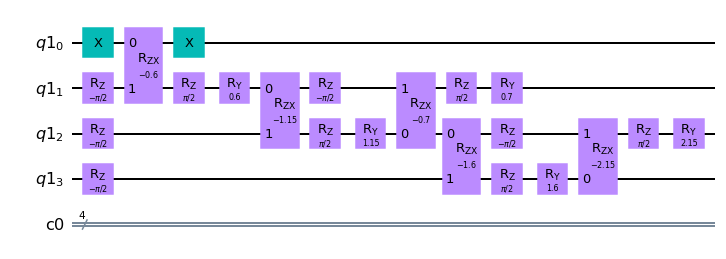

In [14]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = U(cir_i,[1.2,2.3,1.4,3.2,4.3])

tst.draw(output = 'mpl')

In [15]:
psi1 = qi.Statevector.from_instruction(tst)
psi1

Statevector([ 0.82533561-3.32575038e-16j,  0.        +0.00000000e+00j,
              0.23064936+4.19162655e-17j,  0.        +0.00000000e+00j,
              0.00969483+8.52100742e-17j,  0.        +0.00000000e+00j,
             -0.01151011+4.83283335e-17j,  0.        +0.00000000e+00j,
              0.27774892-1.10858346e-16j,  0.        +0.00000000e+00j,
             -0.32975514+2.54109877e-17j,  0.        +0.00000000e+00j,
              0.18165638+2.84033581e-17j,  0.        +0.00000000e+00j,
             -0.21567005+1.78114198e-17j,  0.        +0.00000000e+00j],
            dims=(2, 2, 2, 2))


Now we will do the off diagonal blocks.  

In [16]:

def U_off(cir_i,phi_a,p_label, phi_b):  
    #Run Ua
    cir_i.h(0)
    cir_i = apply_CRy(phi_a[0],cir_i,0,1)
    for q in range(1,Q):
        cir_i = apply_CRy(phi_a[2*q-1],cir_i,q,q+1)
        cir_i = apply_CRy(phi_a[2*q],cir_i,q+1,q)
    cir_i.h(0)
    #Insert Pauli
    for q in range(1,Q+1):
        if p_label[Q-q] == 'X':
            cir_i.x(q)
        if p_label[Q-q] == 'Y':
            cir_i.y(q)
        if p_label[Q-q] == 'Z':
            cir_i.z(q)
    #Run Ua^dagger = Ua^transpose
    cir_i.h(0)
    for q in range(1,Q):
        Lphi = len(phi_b)
        cir_i = apply_CRy(-phi_b[Lphi-2*q+1],cir_i,Q-q+1,Q-q)
        cir_i = apply_CRy(-phi_b[Lphi-2*q],cir_i,Q-q,Q-q+1)
    cir_i = apply_CRy(-phi_b[0],cir_i,0,1)
    cir_i.h(0)
    
    
    return cir_i

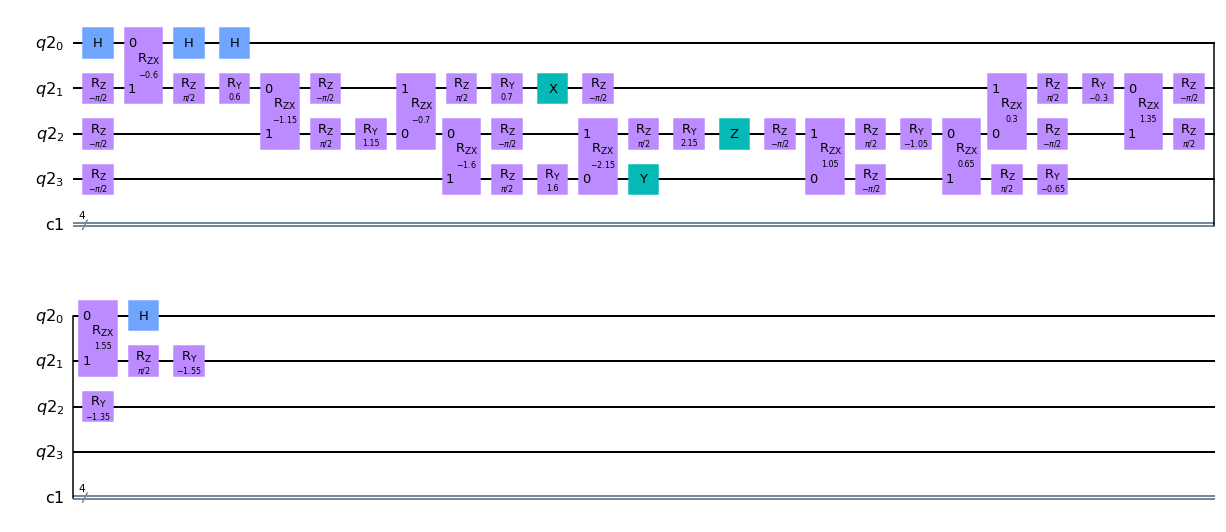

In [17]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
#tst = Ui_off(cir_i,[1.2,2.3,1.4,3.2,4.3],[1.2,2.3,1.4,3.2,4.3]) This should be identity 
tst = U_off(cir_i,[1.2,2.3,1.4,3.2,4.3],'YZX',[3.1,2.7,0.6,1.3,2.1])

tst.draw(output = 'mpl')

In [18]:
psi1 = qi.Statevector.from_instruction(tst)
psi1

Statevector([-1.63184474e-16-0.12114048j,  5.41883857e-17+0.12114048j,
             -1.56095616e-16-0.41209868j, -3.93373170e-17-0.07723294j,
              5.75599476e-17+0.03300209j, -9.37887575e-17-0.18813624j,
              5.35104658e-17+0.12869647j, -7.29701823e-17-0.23852975j,
             -1.51925909e-16-0.26976388j,  1.25037639e-16+0.26976388j,
             -7.09724978e-17-0.33535513j, -1.25783294e-17-0.19935776j,
             -2.13723224e-16-0.37130315j,  5.00847910e-17+0.16723416j,
             -1.34068521e-16-0.20798084j, -1.45203841e-16-0.42198947j],
            dims=(2, 2, 2, 2))


In [19]:
(1+0.183966)/2

0.591983

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



### Stratagy

In order to run on the quantum device, I would like to group together all of the runs so that each time I measure energy, I only have to que once.  

1) We prepare the circuit to be measured for a given p_label and include measurment instructions.
    
    -> add an entry to the measurement instructions to tell if the block is off or on diagonal 
    
    -> if off diagonal the context of the measurment is changed.  meas = [['on'],[a,b,c]] or [['off']]

2) We collect all of the p_labels from a block into a circuit array

3) We collect all of the blocks into a circuit array

4) we send to the backend

5) we use the measurment instructions to decode the results
    
    ->if on diagonal use [a,b,c] to determine the sign of each entry
    
    ->if off-diagonal use $2\sqrt{p_{00...}}-1$

6) sum everything together to get the energy

### Prepare the circuits

This is where I left off.

In [20]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
phi = []
for b in range(bL):
    phi_b = []
    for q in range(2*Q-1):
        rand = random.random()
        phi_b.append(rand)
    phi.append(phi_b)

XII
[1, 0, 0, 0]


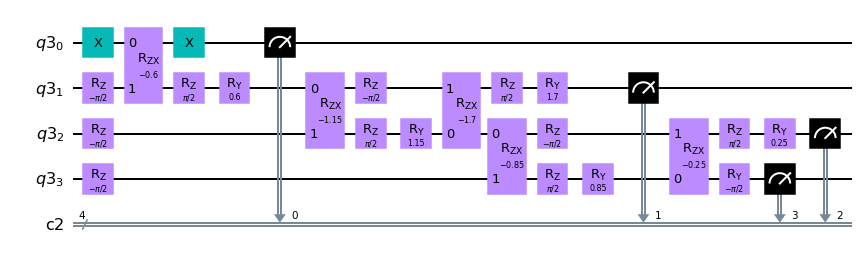

In [21]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def convert_to_circ(p_label,psi0):
    #apply rotations
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    pauli_qs.append(0)
    #apply measurment 
    psi.measure(psi.qubits,psi.clbits)
    #return circut and measurement instructions
    return [psi,pauli_qs]


#Run a test
import copy
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[1.2,2.3,3.4,1.7,0.5])
p_label = blocks['0,0'][10].primitive.to_label()
        
    
cir_tst, lab_tst =  convert_to_circ(p_label,psi0) 
print(p_label)
print(lab_tst)
cir_tst.draw(output = "mpl")

### Collect the circuits

0.5
['on', [1, 0, 0, 0]]
XII


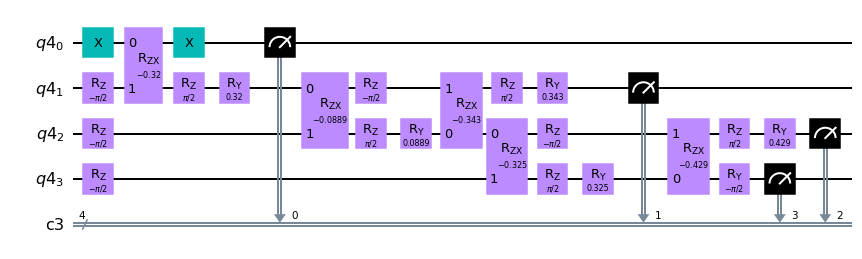

In [22]:
#This collects the circuits for the on-diagonal blocks only
def collect_diag_circs(phi_b,block):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    cirs = []
    meas = []
    coef = []
    pauli = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0:
            p_label = p.primitive.to_label()
            cir_p,meas_p  = convert_to_circ(p_label,psi)
            cirs.append(cir_p)
            meas.append(['on',meas_p])
            coef.append(w)
            pauli.append(p_label)
    return cirs,meas,coef,pauli

block = blocks['0,0']
phi_b = phi[0]

circs, meas, coefs, pauli = collect_diag_circs(phi_b,block)

n=10
print(coefs[n])
print(meas[n])
print(pauli[n])
circs[n].draw(output = "mpl")

-0.25
['off']
IZI


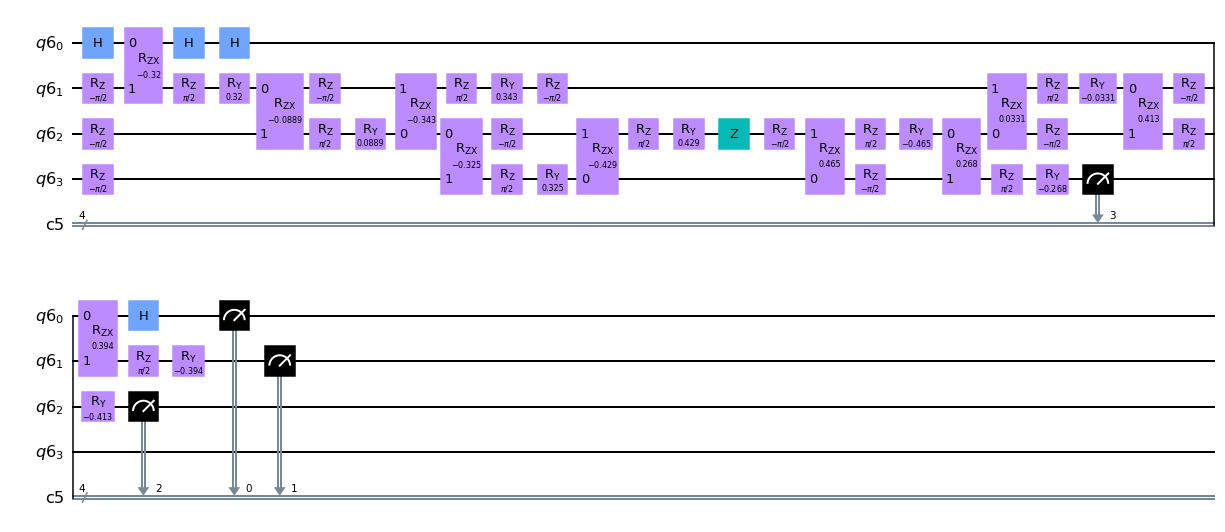

In [23]:
# This collects circuits for both on and off diagonal blocks but is unefficient for on-diagonal blocks
def collect_off_circs(phi_a,phi_b,block):
    cirs = []
    meas = []
    coef = []
    pauli = []
    for p in block:
        p_label = p.primitive.to_label()
        qr = QuantumRegister(Q+1)
        cr = ClassicalRegister(Q+1)
        cir = QuantumCircuit(qr , cr)
        psi0 = U_off(cir,phi_a,p_label,phi_b)
        psi = copy.deepcopy(psi0)
        psi.measure(psi.qubits,psi.clbits)
        w = p.coeff
        if np.abs(w) > 0.0:
            cirs.append(psi)
            meas.append(['off'])
            coef.append(w)
            pauli.append(p_label)
    return cirs,meas,coef,pauli


block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]

circs, meas, coefs, pauli = collect_off_circs(phi_a,phi_b,block)

n=1
print(coefs[n])
print(meas[n])
print(pauli[n])
circs[n].draw(output = "mpl")

192
0.08333333333333336
['on', [1, 0, 0, 0]]
['0,0', 'XII']


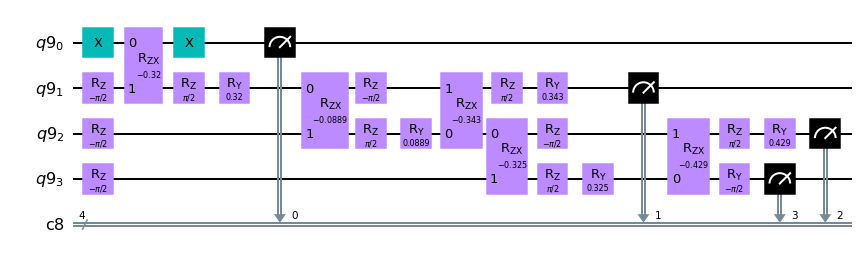

In [24]:
# collect all the circuits 
# The off diagonal coefs are doubled to take care of the Hermition conjugate
def collect_circs(alpha,phi,blocks):
    circs = []
    meas = []
    coefs = []
    paulis = []
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            circ_b, meas_b, coef_b, pauli_b = collect_diag_circs(phi[int(key[0])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
                paulis.append([key,pauli_b[b]])
        else:
            circ_b, meas_b, coef_b, pauli_b = collect_off_circs(phi[int(key[0])],phi[int(key[2])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
                paulis.append([key,pauli_b[b]])
    return circs, meas, coefs, paulis

circs, meas, coefs, paulis = collect_circs(alpha,phi,blocks)

n=10
print(len(circs))
print(coefs[n])
print(meas[n])
print(paulis[n])
circs[n].draw(output = "mpl")

### Run function

In [25]:
circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)

def get_results(circs, method = 'matrix',save_id_file = None):
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts()
        
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
        
        
    return r

r = get_results(circs, method = 'matrix')
#r = get_results(circs, method = 'simulator')
#r = get_results(circs, method = 'quantum')

### Analyze results

In [47]:
def energy_from_results(r,meas,coefs):
    E = 0
    key000 = "".join(['0' for i in range(Q+1)])
    for l in range(len(r)):
        if meas[l][0] == 'on': 
            z_measure = 0
            total = 0
            for key in list(r[l].keys()):
                n = 0
                for q in range(len(key)):
                    if key[q] == '1' and meas[l][1][q] == 1:
                        n += 1
                z_measure += (-1)**n * r[l][key] 
                total += r[l][key]
            E += coefs[l]*z_measure/total
        elif meas[l][0] == 'off':
            total = np.sum([r[l][key] for key in list(r[l].keys())])
            p0 = r[l][key000]/total
            E += 2*coefs[l]*( 2*np.sqrt(p0) - 1 )
    return np.real(E)

energy_from_results(r,meas,coefs)

2.244029111812809

In [48]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

IxH = np.kron(H_complete,[[1,0],[0,1]])
np.dot(np.conjugate(wave_full),np.dot(IxH,wave_full))


(2.2440291118128077-3.0814879110195774e-32j)

In [55]:
#Check Simulator
circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'simulator')
energy_from_results(r,meas,coefs)

2.234972811486861

In [59]:
#Check Quantum
#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_check"
#circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
#r = get_results(circs, method = 'quantum', save_id_file = save_id_file)
#energy_from_results(r,meas,coefs)

620a7888ebacf3defd7d6ebe


3.615977884236631

In [61]:
#function to test each block
#Used for debugging not for running the algorithm
def E_block(b_label):
    h00 = blocks[b_label].to_matrix()
    Ixh00 = np.kron(h00,[[1,0],[0,1]])

    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir1 = QuantumCircuit(qr , cr)
    psi1 = U(cir1,phi[int(b_label[0])])
    cir2 = QuantumCircuit(qr , cr)
    psi2 = U(cir2,phi[int(b_label[2])])


    wave1 = qi.Statevector.from_instruction(psi1).data
    wave2 = qi.Statevector.from_instruction(psi2).data
    return alpha[b1]*alpha[b2]*np.dot(np.conjugate(wave2),np.dot(Ixh00,wave1))

### Ended Constrution

It looks like everything has been fixed.  I should delete the debugging cells and continue onto the optimization part.  
There are debuging cells above and below.  

Think about keeping some of the dubguging equipment in case I need it later.  Espesially the E_Block function

In [189]:
#Set alpha and phi to initial value

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create initail rotation angles
phi = []
for b in range(bL):
    phi_b = []
    for q in range(2*Q-1):
        phi_b.append(0)
    phi.append(phi_b)
    
circs, meas, coefs, paulis = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
energy_from_results(r,meas,coefs)

2.6666666666666683

### Grouping three energies to be run together

In the optimization below we use three energies at each step.  One for the current values and two to define the derivetive.  Since the bottle neck is sending jobs to the device, it will be useful to group these three energies into one job.

In [66]:
def collect_energy_circs(a1, p1, b1, a2, p2, b2, a3, p3, b3):
    circs1, meas1, coefs1, paulis1 = collect_circs(a1,p1,b1)
    circs2, meas2, coefs2, paulis2 = collect_circs(a2,p2,b2)
    circs3, meas3, coefs3, paulis3 = collect_circs(a3,p3,b3)
    L1 = len(circs1)
    L2 = len(circs2)
    L3 = len(circs3)
    circs = circs1+circs2+circs3
    meas = meas1+meas2+meas3
    coefs = coefs1+coefs2+coefs3
    lengths = [L1,L2,L3]
    return circs,meas,coefs,lengths

def three_energies_from_results(r,meas,coefs,lengths):
    L1 = lengths[0]
    L2 = lengths[1]
    L3 = lengths[2]
    r1 = r[0 : L1]
    r2 = r[L1 : L1+L2]
    r3 = r[L1+L2 : L1+L2+L3]
    m1 = meas[0 : L1]
    m2 = meas[L1 : L1+L2]
    m3 = meas[L1+L2 : L1+L2+L3]
    c1 = coefs[0 : L1]
    c2 = coefs[L1 : L1+L2]
    c3 = coefs[L1+L2 : L1+L2+L3]
    E1 = energy_from_results(r1,m1,c1)
    E2 = energy_from_results(r2,m2,c2)
    E3 = energy_from_results(r3,m3,c3)
    return E1,E2,E3
    

In [67]:
circs, meas, coefs, lengths = collect_energy_circs(alpha,phi,blocks,alpha,phi,blocks,alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
E1,E2,E3 = three_energies_from_results(r,meas,coefs,lengths)
print(E1,E2,E3)

2.6666666666666683 2.6666666666666683 2.6666666666666683


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [198]:
import copy
#beta = 0.602
beta = 0.201 #0.05 #0.201
A = 10 #10
a = 0.05  #0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

In [199]:
tt = t

def SPSA(k_max,method = 'matrix', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for q in range(len(Delta_k[b])):
                Delta_k[b][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            #print(tt)
            #print(save_id_file)
            circs_A, meas_A, coefs_A, pauli_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B, pauli_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f, pauli_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [200]:
out = SPSA(2000,method = 'matrix',hold = True)

0 2.6666666666666683
1 2.4523455944586785
2 2.0788920565899143
3 2.10550156348822
4 2.0932931408784903
5 2.1071164611677635
6 2.05675695203479
7 1.8985360323516802
8 1.9906133388205665
9 1.9164769615178827
10 1.9027712825358325
11 1.902220708955131
12 1.2846884606176712
13 1.3419761146675775
14 0.998065116886375
15 0.8320538578348096
16 0.837498294594067
17 0.7965596215794274
18 0.06675346905881074
19 -0.0740288935945701
20 0.034428359902837435
21 -0.04277035402243634
22 -0.27573072771612717
23 -0.21739475771859773
24 -0.1461569923361068
25 -0.116818945479361
26 -0.11608599478162279
27 -0.10676231597593205
28 -0.13184876672941837
29 -0.2008200784206729
30 -0.2874857533020854
31 -0.2833769102793533
32 -0.2852082206864716
33 -0.3099548757771226
34 -0.3432153241259711
35 -0.368827305920544
36 -0.41721538967584604
37 -0.41783211370316875
38 -0.4052318241983793
39 -0.40362497011431486
40 -0.4244174880761912
41 -0.4313306169844256
42 -0.49265184677901824
43 -0.479441544764041
44 -0.498592324

347 -1.0746298518743405
348 -1.0517282118112314
349 -1.044143207396649
350 -1.0414480241372353
351 -1.0275134608789147
352 -1.0168237348511275
353 -1.0184434090065309
354 -1.0185555635832881
355 -1.0305231143324147
356 -0.9966421054966337
357 -1.0307796271188416
358 -1.0503075171268428
359 -1.032273843064829
360 -1.0274928599030322
361 -1.0711720690437105
362 -1.0613360320330985
363 -1.0516663916275064
364 -1.0536337328546914
365 -1.055901750912942
366 -1.0340428410031564
367 -1.0457310395298878
368 -1.045368846965634
369 -1.0768980248940967
370 -1.092572683224413
371 -1.0829535671504777
372 -1.0834064326526875
373 -1.1200622856913103
374 -1.0906363131174877
375 -1.0938704342740035
376 -1.1238671103354887
377 -1.150363630840409
378 -1.1664174840723298
379 -1.157034825804948
380 -1.1768015231431475
381 -1.1855553792771332
382 -1.187044746420223
383 -1.1718396621197638
384 -1.1747440992600577
385 -1.15410313615302
386 -1.1615604125657577
387 -1.1636684688936587
388 -1.1322742673694604
38

693 -1.3152013184998204
694 -1.3017759792400196
695 -1.3452593860157285
696 -1.343490285554676
697 -1.3643248585229983
698 -1.3542970769050164
699 -1.3545825290196194
700 -1.3419858086782988
701 -1.351068482868938
702 -1.355707888310047
703 -1.3430477738448567
704 -1.342885315685176
705 -1.3329341387944735
706 -1.3323625449422503
707 -1.3298646858583882
708 -1.3315971797298571
709 -1.3326426609059987
710 -1.3474750865338412
711 -1.3538855271362056
712 -1.364421971070176
713 -1.324259610282146
714 -1.3276851953083768
715 -1.3367038403932248
716 -1.3418434182549268
717 -1.340509280892476
718 -1.3239776955567564
719 -1.2984291659839116
720 -1.278696371060032
721 -1.2785067380248276
722 -1.3244179639946978
723 -1.3081438363081623
724 -1.3171271458270057
725 -1.3121460004290273
726 -1.2976728236718584
727 -1.2958100638766292
728 -1.302020594279984
729 -1.302576240525725
730 -1.3146392679252374
731 -1.3170545677573142
732 -1.3177985216649202
733 -1.316368548176719
734 -1.3101924167749726
735

1037 -1.3261081174587106
1038 -1.3393280792974145
1039 -1.3438430810668016
1040 -1.3389284013758498
1041 -1.3337687138311165
1042 -1.3400084155254102
1043 -1.340039728411454
1044 -1.3278775668512597
1045 -1.3283575873230262
1046 -1.3273593575898917
1047 -1.3156128997977234
1048 -1.3066045552883694
1049 -1.2959191563033683
1050 -1.289432938862592
1051 -1.2893285360756923
1052 -1.2809111297209417
1053 -1.273520031342842
1054 -1.276877804367493
1055 -1.3057867620864183
1056 -1.3319247972373967
1057 -1.3248350559055617
1058 -1.3244105537360547
1059 -1.3138499371650678
1060 -1.3065202828246079
1061 -1.2977403553738258
1062 -1.307224346002047
1063 -1.3085186722309354
1064 -1.3037521806459083
1065 -1.3146585977777177
1066 -1.3146903360216797
1067 -1.3151885598840858
1068 -1.3192437989415269
1069 -1.3208718362195842
1070 -1.3211403437570355
1071 -1.3131469975087782
1072 -1.3132384042010354
1073 -1.3309585738940308
1074 -1.3308185224507583
1075 -1.3299245232310524
1076 -1.3353228343166537
1077 

1368 -1.377883119150068
1369 -1.3813103425809827
1370 -1.3791454034059645
1371 -1.3764028398949149
1372 -1.3665646724785796
1373 -1.3638518751635864
1374 -1.3513336325819572
1375 -1.3555378540070389
1376 -1.3911769556993914
1377 -1.380914644704087
1378 -1.3805658584835667
1379 -1.3802685741744845
1380 -1.3806758538030512
1381 -1.3846254056760912
1382 -1.385304259376892
1383 -1.38450234052169
1384 -1.372756626690567
1385 -1.3803975114971754
1386 -1.3749517218505383
1387 -1.37540179527632
1388 -1.375059190294822
1389 -1.3804708619401012
1390 -1.378226597605256
1391 -1.3749585269208853
1392 -1.3748538690307184
1393 -1.3725137751821963
1394 -1.3770062532763168
1395 -1.3776742755068752
1396 -1.3784624233445146
1397 -1.3731418375079525
1398 -1.37477967347612
1399 -1.3757595221611678
1400 -1.3801758036413048
1401 -1.3820817047147766
1402 -1.3782202397024514
1403 -1.3712667491358799
1404 -1.3691273699728135
1405 -1.375436466863499
1406 -1.3797839354862973
1407 -1.3766012709646627
1408 -1.36818

1700 -1.4113185191811843
1701 -1.421244595518711
1702 -1.4247731647314397
1703 -1.4300341400021073
1704 -1.4301819841246501
1705 -1.4263342278261408
1706 -1.4309305854534686
1707 -1.4236004448305681
1708 -1.44046511220068
1709 -1.4416368601070808
1710 -1.436164128178438
1711 -1.4377071925169005
1712 -1.4359758388437172
1713 -1.4459499601095196
1714 -1.4407228726543628
1715 -1.4358049530335917
1716 -1.4316495762729486
1717 -1.4306391303779875
1718 -1.4311678444350044
1719 -1.4260646083229647
1720 -1.4261340182247821
1721 -1.4339727767147452
1722 -1.4339372591276836
1723 -1.426205391291486
1724 -1.4277909129144044
1725 -1.420865380770921
1726 -1.4214631830775044
1727 -1.4226590796700054
1728 -1.4229923096749861
1729 -1.4133271559253489
1730 -1.4045109871477144
1731 -1.3937303989898737
1732 -1.3985629998401947
1733 -1.3922723322525539
1734 -1.3825459039613404
1735 -1.37606726460369
1736 -1.3807022598838026
1737 -1.3845769820435225
1738 -1.421864899133358
1739 -1.4208269539207377
1740 -1.4

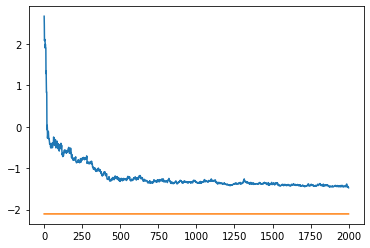

In [201]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

### End of construction

I did go ahead and fix the optimization function below so that it matchs the one above but it has not been tested.  

In [157]:
k=0
job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
job_info = backend.retrieve_job(job_id[0])
hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
            

In [109]:
#beta = 0.602
beta = 0.201
A = 100 #10
a = 0.5  #0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

tt = t

def SPSA_from_load(k_min,k_max,load,method = 'simple', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = load['phi']
    alpha_k = load['alpha']
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_min,k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for q in range(len(Delta_k[b])):
                Delta_k[b][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_A, meas_A, coefs_A, pauli_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B, pauli_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f, pauli_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [206]:
total = out

In [207]:
#out = SPSA_from_load(1,200,hold[0],method = 'quantum',hold = True)
out = SPSA_from_load(1999,3000,total[1999],method = 'matrix',hold = True)

1999 -1.4719751447631797
2000 -1.4745649387861846
2001 -1.4706694870835546
2002 -1.467748519016237
2003 -1.464056832967467
2004 -1.4648107536602393
2005 -1.4660874853764718
2006 -1.4747121915356542
2007 -1.4760968859894095
2008 -1.4761610657549133
2009 -1.474066472884745
2010 -1.4663564263018811
2011 -1.4663677959599464
2012 -1.4686865369459767
2013 -1.4724160561094433
2014 -1.4717687733935267
2015 -1.463772626442838
2016 -1.4664653359504778
2017 -1.4667137466940203
2018 -1.4775143443865253
2019 -1.4775097021796708
2020 -1.46598326257258
2021 -1.4603065365651438
2022 -1.4563828372783105
2023 -1.4548058350111708
2024 -1.4647771982541777
2025 -1.461708665415098
2026 -1.4575463923572456
2027 -1.4620255938838722
2028 -1.4627973691455418
2029 -1.463882012997115
2030 -1.4527461233127057
2031 -1.445653319064577
2032 -1.4400038887806526
2033 -1.4476855846041081
2034 -1.4477491343833344
2035 -1.4411566830591942
2036 -1.4410947275190393
2037 -1.4407739897721306
2038 -1.434041217069147
2039 -1.44

2331 -1.4848086531664522
2332 -1.4883029199466056
2333 -1.4803512441673088
2334 -1.488329113521687
2335 -1.4874036101942365
2336 -1.491071818286012
2337 -1.491604365906366
2338 -1.4904709946294445
2339 -1.491377447293048
2340 -1.4916901552333357
2341 -1.4865395580678975
2342 -1.4801261266315213
2343 -1.4799116100975336
2344 -1.5012452312242766
2345 -1.5011376909726122
2346 -1.496302970459262
2347 -1.496220841093753
2348 -1.4894024435002922
2349 -1.4851693505577164
2350 -1.4849943092934264
2351 -1.475717931644732
2352 -1.4795809373990252
2353 -1.481348651466404
2354 -1.4851642704150743
2355 -1.4955733767182453
2356 -1.49782856806999
2357 -1.4986132663127762
2358 -1.498465787274398
2359 -1.4987988808516042
2360 -1.4977549307479427
2361 -1.496417247025001
2362 -1.496089849409718
2363 -1.4931463961847307
2364 -1.4950174495573014
2365 -1.4848838262594923
2366 -1.487966798124723
2367 -1.4834069487669517
2368 -1.4803688736562988
2369 -1.4794618561701613
2370 -1.4839800249545996
2371 -1.485871

2663 -1.4915063077818052
2664 -1.5039858089433922
2665 -1.5028102656242333
2666 -1.4949442468800935
2667 -1.4931265366317938
2668 -1.49010401176591
2669 -1.4851819814258478
2670 -1.4908666083546644
2671 -1.4906419629165357
2672 -1.4915389968778223
2673 -1.4883800777282643
2674 -1.5077658120967705
2675 -1.5038960416543325
2676 -1.499512094633147
2677 -1.4992944451812662
2678 -1.4964582712025871
2679 -1.4987574288575174
2680 -1.4954975432698239
2681 -1.5016723424671963
2682 -1.496098712445837
2683 -1.4982812987981506
2684 -1.492289319823868
2685 -1.4865366554828063
2686 -1.4827491924897966
2687 -1.4779764684668073
2688 -1.468954941290207
2689 -1.4717120704082018
2690 -1.48028874376197
2691 -1.4837842051075643
2692 -1.484175634163312
2693 -1.4791349361641433
2694 -1.4704944607580805
2695 -1.4647338398103344
2696 -1.4664438879076525
2697 -1.4662316260767208
2698 -1.455721893119168
2699 -1.4591019792051114
2700 -1.4611005557350727
2701 -1.461818967492613
2702 -1.4651608286035982
2703 -1.459

2994 -1.5075351785968194
2995 -1.5083802521990268
2996 -1.5033464529970013
2997 -1.5073581878480697
2998 -1.504226881385761
2999 -1.5037280745213615


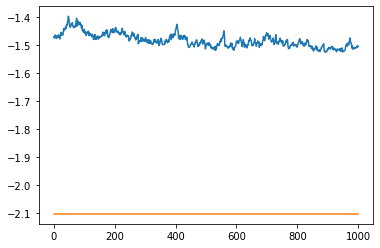

In [208]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [209]:
#total = total+out

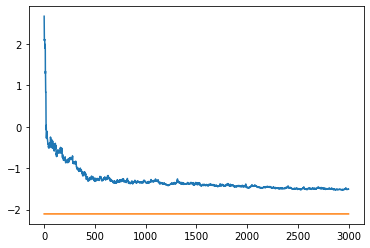

In [210]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(total))]

El = [total[i]['E'] for i in range(len(total))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [161]:
import numpy as np
El = []
kl = []
out = []
for k in range(0,127):
    job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
    job_info = backend.retrieve_job(job_id[0])
    hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
    out.append(hold[0])
    El.append(hold[0]['E'])
    kl.append(k)

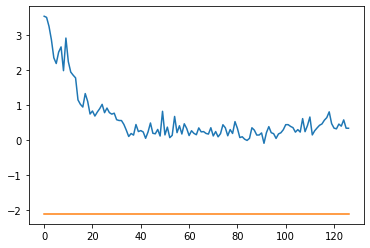

In [162]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(El))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

# Save Data

In [211]:
import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE_CRy_Ansatz/Data/'

file_to_store = open(fpath + "VQE_matrix_new_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [212]:
#A = 20 #10
#a = 0.1  #0.05

import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE_CRY_Ansatz/Data/'

file_to_read = open(fpath + "VQE_matrix_new_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

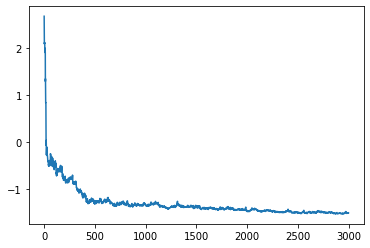

In [213]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)